<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebook/plantseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PlantSegを用いた染色画像の細胞インスタンス・セグメンテーション

<img src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/d9e2211b9f7ee3748313c79760ec852913449e62850677539cca9e381e1e9c09.png" alt="Image" style="background-color: white;">
plantsegの公式レポジトリより転載<sup>1</sup>

## 解説
植物の細胞壁をなんらかの試薬で染色、もしくは蛍光タンパク質で光らせ、共焦点顕微鏡で撮影する状況があるとします。どんなに染色条件や顕微鏡の撮影条件を検討しても、染色ムラや光の散乱や減衰、さらには屈折率の不均一性などの理由で、均一に細胞壁を検出した画像を取得することは大変難しいことかと思います。もし均一に取ることができれば１視野にある無数の細胞の形を自動計測し、遺伝子の機能解析や発生モデルの構築などに役立てられるのに、現実はそうではなく、大変な補正作業が入ることが多いですね。

PlantSeg<sup>2</sup>は、共焦点顕微鏡やライトシート顕微鏡を用いて取得された3Dボリューム画像（2Dも可能です）における細胞インスタンスの認識を可能にするツールです​​。このツールは、主に植物細胞組織の染色画像に対してチューニングされており、訓練済みのモデルも提供されています​。

PlantSegは、2つのステップから構成されています​。

1. 細胞境界の予測：2D/3D U-Netを用い、細胞の境界領域を検出・抽出します。具体的には自家蛍光や染色由来のシグナル強度を均一化し、細胞壁の欠落やぼやけなど）を修正することができます​。
2. 細胞セグメンテーション：４種類の領域分割アルゴリズムが実装されています。
    - Multicut
    - GASP average
    - Mutex watershed
    - Distance transform watershed

PlantSegの出力フォーマットはHierarchical Data Format (HDF5)またはTagged Image File Format (TIFF)であり、本ソフトを前処理として活用した後、ilastik、MorphographX、Fijiといったよく使われる画像解析ソフトで引き続き解析を行うことも可能です。

## 環境構築

In [ ]:
#このセルを実行するとcolabが再起動（セッションがクラッシュしたと表示）しますが正常な動作です。
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# takes time. grab some coffee and wait
!conda install -c conda-forge mamba
!mamba install -c pytorch -c nvidia -c conda-forge -c lcerrone plantseg pytorch-cuda=11.7
!pip install PyYAML

## 解析設定

In [ ]:
#Movie1_t00006_crop_gt.h5
!wget -O test_movie.h5 https://osf.io/63kje/download

In [2]:

# yaml fileを自作する
import yaml

INPUT_PATH = "/content/XXXX.tiff"

data = {
    # Contains the path to the directory or file to process
    "path": INPUT_PATH,
    "preprocessing": {
        # enable/disable preprocessing
        "state": True,
        # create a new sub folder where all results will be stored
        "save_directory": "PreProcessing",
        # rescaling the volume is essential for the generalization of the networks. The rescaling factor can be computed as the resolution
        # of the volume at hand divided by the resolution of the dataset used in training. Be careful, if the difference is too large check for a different model.
        "factor": [1.0, 1.0, 1.0],
        # the order of the spline interpolation
        "order": 2,
        # cropping out areas of little interest can drastically improve the performance of plantseg.
        # crop volume has to be input using the numpy slicing convention [b_z:e_z, b_x:e_x, b_y:e_y], where b_zxy is the
        # first point of a bounding box and e_zxy is the second. eg: [:, 100:500, 400:900]
        "crop_volume": "[:,:,:]",
        # optional: perform Gaussian smoothing or median filtering on the input.
        "filter":{
            # enable/disable filtering
            "state": False,
            # Accepted values: 'gaussian'/'median'
            "type": "gaussian",
            # sigma (gaussian) or disc radius (median)
            "filter_param": 1.0
            }
        },
    "cnn_prediction":{
        # enable/disable UNet prediction
        "state": True,
        # Trained model name, more info on available models and custom models in the README
        "model_name": "generic_confocal_3D_unet",
        # If a CUDA capable gpu is available and corrected setup use "cuda", if not you can use "cpu" for cpu only inference (slower)
        "device": "cuda",
        # how many subprocesses to use for data loading
        "num_workers": 8,
        # patch size given to the network (adapt to fit in your GPU mem)
        "patch": [100, 160, 160],
        # stride between patcheswill be computed as `stride_ratio * patch`
        # recommended values are in range `[0.5, 0.75]` to make sure the patches have enough overlap to get smooth prediction maps
        "stride_ratio": 0.75,
        # If "True" forces downloading networks from the online repos
        "model_update": False,
        },

    "cnn_postprocessing":{
        # enable/disable cnn post processing
        "state": False,
        # if True convert to result to tiff
        "tiff": False,
        # rescaling factor
        "factor": [1, 1, 1],
        # spline order for rescaling
        "order": 2
    },

    "segmentation":{
        # enable/disable segmentation
        "state": True,
        # Name of the algorithm to use for inferences. Options: MultiCut, MutexWS, GASP, DtWatershed
        "name": "MultiCut",
        # Segmentation specific parameters here
        # balance under-/over-segmentation; 0 - aim for undersegmentation, 1 - aim for oversegmentation. (Not active for DtWatershed)
        "beta": 0.5,
        # directory where to save the results
        "save_directory": "MultiCut",
        # enable/disable watershed
        "run_ws": True,
        # use 2D instead of 3D watershed
        "ws_2D": True,
        # probability maps threshold
        "ws_threshold": 0.5,
        # set the minimum superpixels size
        "ws_minsize": 50,
        # sigma for the gaussian smoothing of the distance transform
        "ws_sigma": 2.0,
        # sigma for the gaussian smoothing of boundary
        "ws_w_sigma": 0,
        # set the minimum segment size in the final segmentation. (Not active for DtWatershed)
        "post_minsize": 50
        },
    "segmentation_postprocessing":{
        # enable/disable segmentation post processing
        "state": False,
        # if True convert to result to tiff
        "tiff": False,
        # rescaling factor
        "factor": [1, 1, 1],
        # spline order for rescaling (keep 0 for segmentation post processing
        "order": 0,
        # save raw input in the output segmentation file h5 file
        "save_raw": False
    }
}

with open('config.yaml', 'w') as file:
    yaml.dump(data, file)


## 実行

In [41]:
!plantseg --config /content/config.yaml

2023-06-13 13:24:59,661 [MainThread] WARNING PlantSeg - key: 'patch_halo' is missing, plant-seg is trying to use a default.
2023-06-13 13:24:59,661 [MainThread] WARNING PlantSeg - key: patch_halo has got value: None, but value must be a list (or tuple). defaulting default value: [2, 4, 4]
2023-06-13 13:24:59,661 [MainThread] WARNING PlantSeg - key: 'output_type' is missing, plant-seg is trying to use a default.
2023-06-13 13:24:59,661 [MainThread] WARNING PlantSeg - key: output_type has got value: None, but value must be a string. defaulting default value: data_float32
2023-06-13 13:24:59,661 [MainThread] WARNING PlantSeg - key: 'save_raw' is missing, plant-seg is trying to use a default.
2023-06-13 13:24:59,661 [MainThread] WARNING PlantSeg - key: save_raw has got value: None, but value must be a bool. defaulting default value: False
2023-06-13 13:24:59,661 [MainThread] INFO PlantSeg - Running the pipeline on: ['/content/test_movie.h5']
2023-06-13 13:24:59,661 [MainThread] INFO PlantS

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [31]:
len(frames)

486

KeyboardInterrupt: ignored

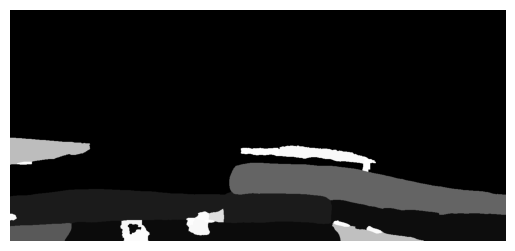

In [39]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Path to your HDF5 file
filename = '/content/PreProcessing/generic_confocal_3D_unet/MultiCut/test_movie_predictions_multicut.h5'
with h5py.File(filename, 'r') as file:
    # The dataset is named 'segmentation', automatically retreive it.
    images = np.array(file[list(file.keys())[0]])

# Create a figure for the animation
fig, ax = plt.subplots()

# Function to update the frame in the animation
def update(frame):
    ax.imshow(images[frame], cmap='gray')
    ax.axis('off')

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(images.shape[0]), interval=50)

# Display the animation
HTML(ani.to_jshtml())

1. https://github.com/hci-unihd/plant-seg/
    - MIT License
2. Wolny, A. et al., (2020). Accurate and versatile 3D segmentation of plant tissues at cellular resolution. eLife, 9. https://doi.org/10.7554/eLife.57613